## Paddy Kaggle Notebook (Pytorch ported to FastAI)

In [6]:
def do_setup():
    # How to download competition data to temp folder(data) 
    # unzip it there, then symlink it like its a subdir
    # NOTE: make sure kaggle.json is in /root/.kaggle/

    #remove original symlink from this directory
    !rm ./data
    
    #remove old setup files
    !rm setup.sh

    #create temp holder
    !mkdir /root/data

    #symlink it
    !ln -s /root/data ./data

    #download competition data to temp data folder
    !cd ./data;kaggle competitions download -c paddy-disease-classification

    #unzip it, -q is silent
    !cd ./data;unzip -q paddy-disease-classification.zip

    #setup dotfiles
    !wget "https://raw.githubusercontent.com/CNUClasses/dotfiles/master/setup.sh";chmod 766 setup.sh;source ./setup.sh  
    
import os
if(not os.path.exists('./data/train_images')):
   !chmod 600 /root/.kaggle/kaggle.json
   do_setup()  

In [7]:
#install needed libraries
try: from path import Path
except ModuleNotFoundError:
    !pip install path --quiet
    from path import Path
try: import timm
except ModuleNotFoundError:
    !pip install timm --quiet
    import timm
try: import optuna
except ModuleNotFoundError:
    !pip install optuna --quiet
    import optuna    

In [8]:
import torch
import pandas as pd
import torch.optim as optim
from tqdm.auto import tqdm
import sklearn
from sklearn.model_selection import train_test_split
sklearn.__version__
import paddy_funcs_classes as pfc

# autoreload extension
%load_ext autoreload
%autoreload 2

## CFG file

In [9]:
#from https://www.kaggle.com/code/hinepo/transfer-learning-with-timm-models-and-pytorch
class CFG:
    train_path='./data/train_images'   #get train and validation Datasets from here
    test_path='./data/test_images'     #get test set from here
    csv_path='./data/train.csv'
    
    ### split train and validation sets
    split_fraction = 0.2

    ##dataloader
    drop_last=False
    
    ### model
    model_name = 'resnet26d'#'convnext_small_in22k' # ## 'resnet50' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  

    #get a subset of data to work on(start with True until all experiments done
    #and want to train on entire dataset
    subsample_data=False
    BATCH_SIZE= 8 if subsample_data else 32
    N_EPOCHS = 4 if subsample_data else 50
    # print_freq = 2 

    momentum=0.9
    
    ### set only one to True
    save_best_loss = False
    save_best_accuracy = True

    ### optimizer
    # optimizer = 'adam'
    # optimizer = 'adamw'
    optimizer = 'rmsprop'  
    # LEARNING_RATE=0.00001
    LEARNING_RATE_MIN=0.004
    LEARNING_RATE_MAX=0.01

    random_seed = 42

### Get data

In [10]:
df =pd.read_csv(CFG.csv_path)
# df.head()

### EXPERIMENT ON SUBSET OF DATA?

In [11]:
if CFG.subsample_data:
    #stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
    # df, _ = train_test_split(df, test_size=0.5, random_state=0, stratify=df[['label', 'variety']])

#     #get a small dataset to train on
    df=df.iloc[:500,:]

    print(df.shape)

In [12]:
# #get a list of files
trn_val_files=pfc.get_fls(CFG.train_path)  
tst_files=pfc.get_fls(CFG.test_path) 
print(f'Len train={len(trn_val_files)}, length test={len(tst_files)}')

Len train=10407, length test=3469


### Stratified Split data

In [13]:
#stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
train, val = train_test_split(df, test_size=CFG.split_fraction, random_state=0, stratify=df[['label', 'variety']])
len(train) + len(val)

10407

### Get list of transforms that the original model used (mean, std)

In [14]:
cfg=timm.data.resolve_data_config({}, model=CFG.model_name, verbose=True)
cfg

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875}

### Create Datasets

In [15]:
#forward and reverse map labels and varieties
mpr=pfc.mapper(df)

#get transforms
train_transforms, val_transforms=pfc.get_transforms(cfg)

trn_dataset = pfc.MultiTaskDatasetTrain(CFG.train_path,df=train,mpr=mpr,transforms=train_transforms) #use train df
val_dataset = pfc.MultiTaskDatasetTrain(CFG.train_path,df=val,mpr=mpr,transforms=val_transforms)   #use val df
test_dataset= pfc.MultiTaskDatasetTest(CFG.test_path, transforms=val_transforms)            #test set

print(f'Number train images={len(trn_dataset)}, number validation={len(val_dataset)}, and number test images={len(test_dataset)}')

if(not CFG.subsample_data):
    assert(len(trn_dataset)+len(val_dataset)==len(trn_val_files))
    assert(len(test_dataset)==len(tst_files))

Number train images=8325, number validation=2082, and number test images=3469


### Create DataLoaders

In [16]:
from torch.utils.data import DataLoader
trn_dl=DataLoader(trn_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last) #drop last to avoid crash
# trn_dl=DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last) #drop last to avoid crash

val_dl=DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=2,drop_last=CFG.drop_last)

#### Sizes from DataLoader

In [17]:
import matplotlib.pyplot as plt
imgs,lbls,varieties = next(iter(val_dl))
print(f"Feature batch shape: {imgs.size()}")
print(f"Labels batch shape: {lbls.size()}")
print(f"Varieties batch shape: {varieties.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Varieties batch shape: torch.Size([32])


### Define Multi Head Model (2 output params)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR  

class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self,tmodel):
        '''
        tmodel: pretrained model
        ex:
        model_name='resnet26d'
        tmodel=timm.create_model(model_name, pretrained=True)
        m1=DiseaseAndTypeClassifier(tmodel)
        
        '''
        super().__init__()
        self.m = tmodel
        #add an extra layer
        # self.m.fc=nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False)
        self.l1=nn.Linear(in_features=self.m.get_classifier().out_features, out_features=10, bias=False)  #rice type
        self.l2=nn.Linear(in_features=self.m.get_classifier().out_features, out_features=10, bias=False)  #disease
        
    def forward(self,x):       
        x=F.relu(self.m(x)) 
        label=self.l1(x)  #disease type
        variety=self.l2(x)  #variety
        return label,variety

def get_model(model_name, min_lr,max_lr,num_epochs,trn_dl):
    '''
    gets a timm model and wraps in a  DiseaseAndTypeClassifier class
    min_lr: minimum learning rate for OneCycleLR
    max_lr: maximum learning rate for OneCycleLR
    num_epochs: how many epochs to train for
    trn_dl: TRAIN dataloader-used by OneCycleLR to calculate correct number of steps
    cfg:
    '''
    #create the timm model
    tmodel=timm.create_model(model_name, pretrained=True, num_classes=512,global_pool='catavgmax') 

    #and pass it to DiseaseAndTypeClassifier
    m1=DiseaseAndTypeClassifier(tmodel)

    #create optimizer
    optimizer=optim.SGD(m1.parameters(),min_lr, momentum=CFG.momentum)

    #create a learning rate scheduler
    scheduler = OneCycleLR(optimizer, 
                max_lr = max_lr, # Upper learning rate boundaries in the cycle for each parameter group
                steps_per_epoch=int(len(trn_dl)),epochs=num_epochs,
                anneal_strategy = 'cos') # Specifies the annealing strategy

    #create the learner that will train the model
    return pfc.Learner(m1,scheduler,optimizer)


## Put cusom model in FastAI

In [29]:
import fastai
import fastai.tabular.data
from torch.utils.data import Dataset
from fastai.vision.all import *
set_seed(42)
path =Path('./data/')

## get the image files

In [ ]:
trnpath='./

In [30]:
files = get_image_files(path/'train_images')
labels = [f.parent.name for f in files]
variety=[df.loc[df['image_id']==fle.name].iloc[0].variety for fle in files]
print(files[0])
print(labels[0])
print(variety[0])
print(files[0].name)

data/train_images/bacterial_leaf_streak/100081.jpg
bacterial_leaf_streak
Onthanel
100081.jpg


In [31]:
#create a dict to map label strings to tensors
i_to_label=dict(enumerate(df.label.unique()))
label_to_i={v:i for i,v in i_to_label.items()}
# print(i_to_label)
# print(label_to_i)

#create another to map variety strings to tensors
i_to_variety=dict(enumerate(df.variety.unique()))
variety_to_i={v:i for i,v in i_to_variety.items()}

In [33]:
trnpath='./data/train_images'

In [36]:
#creae a dict that maps from image_id to variety
img_id=df.image_id
variety=df.variety

itov=dict(zip(img_id,variety))

def getvariety(p): return itov[p.name]
    

## The below dataloader returns image and label

In [77]:
dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(192,method='squish'),batch_tfms=aug_transforms(size=128, min_scale=0.75))

In [81]:
#thisdatablock ensures that image, label and variety are returned
dblock=DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),   #ImageBlock works if passed a path to image, CategoryBlock works if passed a string to categorify to an int
                 n_inp=1,   #imageblock
                 get_items=get_image_files,
                 get_y=[parent_label,getvariety],  #2 cat blocks ricetype and disease variety type
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=Resize(192,method='squish'),
                 batch_tfms=aug_transforms(size=128, min_scale=0.75))

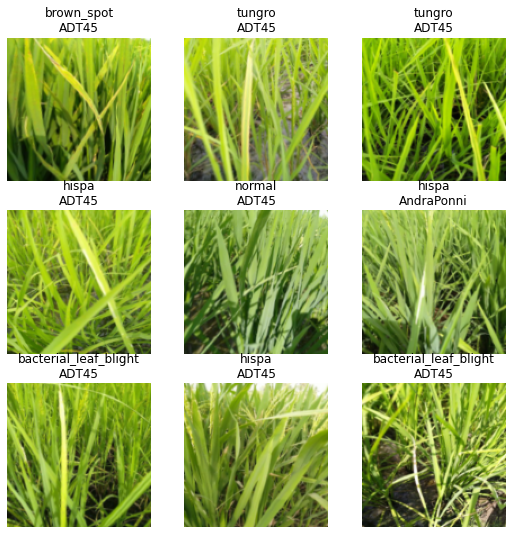

In [85]:
dls=dblock.dataloaders(train_pth)
dls.show_batch()

In [82]:
train_pth=path/'train_images'
ds=dblock.datasets(train_pth)

In [83]:
#test code
# fn=get_image_files(train_pth)[0]
# print(fn)

# # PILImage.create(fn)
# print(parent_label(fn))
# print(getvariety(fn))

# img,y1,y2=ds.train[1]

In [103]:
def dtc_loss(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    c_loss = nn.CrossEntropyLoss()
    return c_loss(rice_preds,y_label)+c_loss(variety_preds,y_variety)

def dtc_error(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    return error_rate(rice_preds,y_label)+error_rate(variety_preds,y_variety)

def acc_labels(preds,y_label,y_variety):
    '''
    preds:[nxn] tensor
    lbls:[1xn] tensor
    sums number of lbl positions that are equivalent to max pred
    then divides by total number of samples
    returns: float between 0 and 1
    '''
    label_preds, variety_preds=preds
    return ((torch.argmax(label_preds,dim=1)==y_label).sum()/len(y_label)).item()

def acc_variety(preds,y_label,y_variety):
    '''
    preds:[nxn] tensor
    lbls:[1xn] tensor
    sums number of lbl positions that are equivalent to max pred
    then divides by total number of samples
    returns: float between 0 and 1
    '''
    label_preds, variety_preds=preds
    return ((torch.argmax(variety_preds,dim=1)==y_variety).sum()/len(y_variety)).item()

In [104]:
from fastai.vision.all import *

#create the timm model
tmodel=timm.create_model('resnet26d', pretrained=True, num_classes=512,global_pool='catavgmax') 

#and pass it to DiseaseAndTypeClassifier
m1=pfc.DiseaseAndTypeClassifier(tmodel)

learn = Learner(dls, model=m1, loss_func=dtc_loss, metrics=[acc_labels,acc_variety ])

In [105]:
learn.loss_func

<function __main__.dtc_loss(preds, y_label, y_variety)>

SuggestedLRs(valley=0.00015848931798245758, slide=0.02754228748381138)

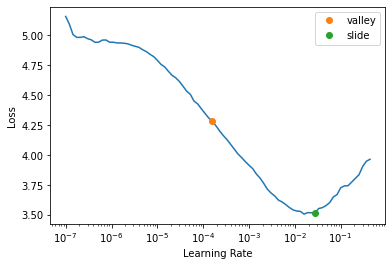

In [106]:
learn.lr_find(suggest_funcs=(valley,slide))

In [107]:
learn.fine_tune(10,0.005)

epoch,train_loss,valid_loss,acc_labels,acc_variety,time
0,2.309319,4.495825,0.214801,0.662662,00:57


epoch,train_loss,valid_loss,acc_labels,acc_variety,time
0,1.095649,0.905530,0.793369,0.918309,00:58
1,0.999848,1.641948,0.664104,0.827967,00:53
2,0.895618,1.299167,0.764056,0.881788,00:57
3,0.713785,0.998206,0.786641,0.926958,00:56
4,0.548015,0.721626,0.850553,0.926478,00:53
5,0.382018,0.589243,0.875060,0.939933,00:57
6,0.218531,0.336766,0.915906,0.974531,00:56
7,0.129183,0.216803,0.955790,0.988948,00:53
8,0.084758,0.214195,0.956271,0.988948,00:56
9,0.068780,0.217386,0.959635,0.987025,00:56


## Predict on the val set 

In [25]:
pfc.get_accuracy(lrn.m,val_dl)  

Accuracy: Label prediction=82.05%,  Variety prediction=90.67


(82.05492424242425, 90.67234848484848)

## Generate submission

In [ ]:
#generate sorted list of files
test_dataset=MultiTaskDatasetTest(CFG.test_path, transforms=val_transforms) 
test_dataset.files.sort()

#generate a non_shuffle dataloader
tst_dl=DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=1,drop_last=False)

#where is the model
device = next(m1.parameters()).device.type

#get model predictions
labels=[]
for imgs in tst_dl:
    imgs = imgs.to(device)

    # forward + backward + optimize
    pred_lbls,_ = lrn.m(imgs)
    
    #get the max index
    pred_lbls=torch.argmax(pred_lbls,dim=1).tolist()
    labels=labels+pred_lbls   

#convert indexes to labels
new_labels=[mpr.i_to_label[i] for i in labels]
# get a list of files
files=[fle.split('/')[-1] for fle in test_dataset.files]   

with open('./submission.csv','w') as fle:
    fle.write('image_id,label')
    for i in range(len(files)):
        fle.write('\n'+files[i]+','+new_labels[i])

## Zip And Upload to Kaggle


In [ ]:
!zip ./submission.zip ./submission.csv
!kaggle competitions submit -c paddy-disease-classification -f submission.zip -m "Message"

## Experiment

In [ ]:
#where is this model located?
# tmodel1=timm.create_model(model_name, pretrained=True, num_classes=13,global_pool='catavgmax')  #going to replace the 13
# next(tmodel1.parameters()).device.type

#     def _one_epoch(self,dl,training):
#         running_loss_labels = 0.0
#         running_loss_varieties = 0.0
#         running_err_rate_labels =0.0
#         running_err_rate_varieties =0.0
#         is_trn=self.m.training
        
#         # for i, data in (enumerate(tqdm(dl), 0)):
#         print()
#         for i, data in (enumerate(dl)):

#             # get the inputs, labels is tuple(label, variety)
#             imgs,lbls,varietys = data[0].to(self.device),data[1].to(self.device),data[2].to(self.device)
           
#             if training:
#                 # zero the parameter gradients
#                 self.optimizer.zero_grad()
 
#             # forward + backward + optimize
#             pred_lbls,pred_varieties = self.m(imgs)
             
#             loss_labels , loss_varieties = self.criterion(pred_lbls,pred_varieties, lbls,varietys)
            
#             if training:
#                 #see https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
#                 loss_labels.backward(retain_graph=True)
#                 loss_varieties.backward()

#             running_loss_labels+=loss_labels.item()
#             running_loss_varieties+=loss_varieties.item()
#             running_err_rate_labels+=error_rate(pred_lbls,lbls)
#             running_err_rate_varieties+=error_rate(pred_varieties,varietys)
 
#             #adjust weights
#             self.optimizer.step()

#             if (i%CFG.print_freq==0):
#                 state='train' if is_trn else 'valid' 
#                 print(f'{state}:err_rate_labels={(running_err_rate_labels/(i)):.2f},   label_loss={(running_loss_labels):.2f},   err_rate_varieties={(running_err_rate_varieties/(i)):.2f}   varieties_loss={(running_loss_varieties):.2f},    ', end='\r', flush=True)
#                 running_loss_labels = 0.0
#                 running_loss_varieties = 0.0
        

In [ ]:
# m1.train()
# m1.eval()
# print(f'{m1.training}, {m1.m.training}, {m1.m.fc.training}')

#check shapes
# (next(iter(trn_dl))[-2:])

# m1.eval()
# m1(trn_dataset[0][0].unsqueeze(0))

 #calls forward
# m1(next(iter(trn_dl))[0]) 
# m1(val_dataset[0].unsqueeze(0))

# m1(torch.randn(1,3,224,224))



# criterion=DiseaseAndTypeClassifierLoss()
# optimizer = optim.SGD(m1.parameters(), lr=0.001, momentum=0.9)
# num_epochs=3
# numb_batches_between_prints=1

        
        
# for epoch in range(num_epochs):  # loop over the dataset multiple times

#     running_loss_labels = 0.0
#     running_loss_varieties = 0.0
#     num_batches=len(trn_dl)/trn_dl.batch_size
#     m1.train()
#     for i, data in (enumerate(tqdm(trn_dl), 0)):

#         # get the inputs, labels is tuple(label, variety)
#         imgs,lbls,varietys = data[0].to(device),data[1].to(device),data[2].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         pred_lbls,pred_varieties = m1(imgs)
        
#         #loss
#         # loss = criterion(pred_lbls,pred_varieties, lbls,varietys)
#         # loss.backward()
#         loss_labels , loss_varieties = criterion(pred_lbls,pred_varieties, lbls,varietys)
#         loss_labels.backward()
#         loss_varieties.backward()
        
#         running_loss_labels+=loss_labels.item()
#         running_loss_varieties+=loss_varieties.item()
        
#         #adjust weights
#         optimizer.step()
        
#         if i%numb_batches_between_prints==0:
#             if(
#             print(f'label_loss={running_loss_labels/(numb_batches_between_prints*batch_size):.2f}, \
#                   varieties_loss={running_loss_varieties/(numb_batches_between_prints*batch_size):.2f}', end='\r', flush=True)
#             running_loss_labels = 0.0
#             running_loss_varieties = 0.0
    
#     # m1.eval()
#     # num_batches=len(val_dl)/batch_size
#     # for i, data in (enumerate(tqdm(val_dl), 0)): 

        
        
 

# # print('Finished Training')

In [ ]:
# a=np.nan
# a

# import math
# assert (math.isnan(a))

In [ ]:
# m1=timm.create_model('resnet26d', pretrained=True, num_classes=10,global_pool='catavgmax')  #going to replace the 13
# m2=timm.create_model(CFG.model_name, pretrained=True, num_classes=10,global_pool='catavgmax')  #going to replace the 13

# def get_fc(m):
#     #when iterator is exhausted, item will hold last layer
#     for item in m.children():
#         pass
#     print(type(item))
#     if(isinstance(item,torch.nn.modules.linear.Linear)):
#         print('Its linear')
#     else:
#         item= get_fc(item)   
#     return item

# fcl=get_fc(m1)
# m2.head.fc=nn.Sequential(
#             nn.Linear(in_features=m1.get_classifier().in_features,out_features=512, bias=False),
#             nn.ReLU())



# m11=DiseaseAndTypeClassifier(m1)
# m22=DiseaseAndTypeClassifier(m2)

# #convnext has no m1.fc, get its head this way
# tmodel.head.fc